# PyTorch Workflow

Let's explore a an example PyTorch end-to-end workflow.

Resources:
* [Gorund Truth Notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/01_pytorch_workflow.ipynb)
* [Book bersion of notebook](https://www.learnpytorch.io/01_pytorch_workflow)
* [Question](https://github.com/mrdbourke/pytorch-deep-learning/discussions)

In [92]:
what_were_covering = {
    1: 'data (prepare and load)',
    2: 'build model',
    3: 'fitting the model to data (training)',
    4: 'making predictions and evaluating a model (inference)',
    5: 'saving and loading a model',
    6: 'putting it all together'
}


what_were_covering


{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [93]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'1.13.1'

 ## 1. Data (Preparing and loading)

Data can be almost anything... in machine learning.

* Excel spreadsheet
* Images of any kind
* Videos (Youtube has lots of data...)
* Audio like songs or podcasts
* DNA
* Text

Machine Learning is a game of two parts:
1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation


To showcase this, let's create some *known* data using the linear regression formula.

We'll use a linear regression formula to make a straight line with *known* **parameters**.


In [94]:
# Create Known Parameters

weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim = 1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [95]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets (one of the most important concepts in machine learning in general)

#### Three datasets
1. Training set: Course materials
2. Validation set: Parctice exam
- Tune model patterns
3. Test set: Final exam
- see if the model is ready for the wild


**Generalization**

The ability for a machin learning model to perform well on data it hasn't seen before.

In [96]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)


(40, 40, 10, 10)

In [97]:
def plot_predictions(train_data=X_train,
                      train_labels=y_train,
                      test_data=X_test,
                      test_labels=y_test,
                      predictions=None):
    '''
    plots training data, test data and compares predictions.
    '''

    plt.figure(figsize=(10, 7))

    # plot training data in blue
    plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')
    
    # Plot test data in green
    plt.scatter(test_data, test_labels, c='r', s=4, label ='Testing data')

    if predictions is not None:
        plt.scatter(test_data, predictions,c='g', s=4,label='Pred')

    plt.legend(prop={'size': 14})


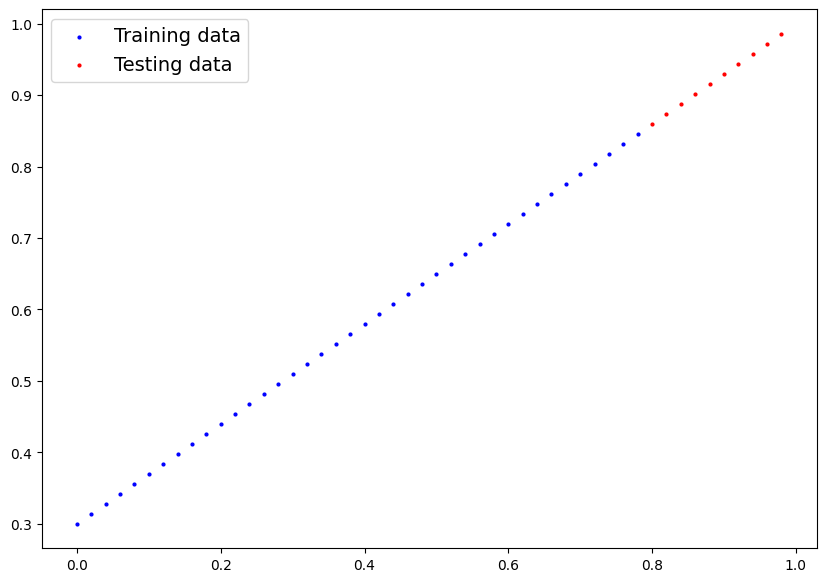

In [98]:
plot_predictions()

## 2. Build model 

### PyTorch model building essentials
- torch.nn
- torch.nn.Parameter
- torch.nn.Module
- torch.optim
- def forward()

In [99]:
import torch.nn as nn
import torch

# Linear regression model
class LinearRegressionModel(nn.Module):# <- nn.Moudle은 거의 모든 곳에서 상속함
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.weights = nn.Parameter(torch.randn(1,
                                                requires_grad=True,
                                                dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                             requires_grad=True,
                                             dtype=torch.float))
        
    # forward method to define the computation in the model
    def forward(self, x:torch.Tensor) -> torch.Tensor: # <- 'x' is the input data
        return self.weights * x + self.bias # linear regression formula
    

In [100]:
# Create a random seed
torch.manual_seed(42)

# Create a instant 
model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [101]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [102]:
list(model_0.named_parameters())

[('weights',
  Parameter containing:
  tensor([0.3367], requires_grad=True)),
 ('bias',
  Parameter containing:
  tensor([0.1288], requires_grad=True))]

In [103]:
# Make predictions with model
# upgrade version of 'with torch.no_grad():'
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [104]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

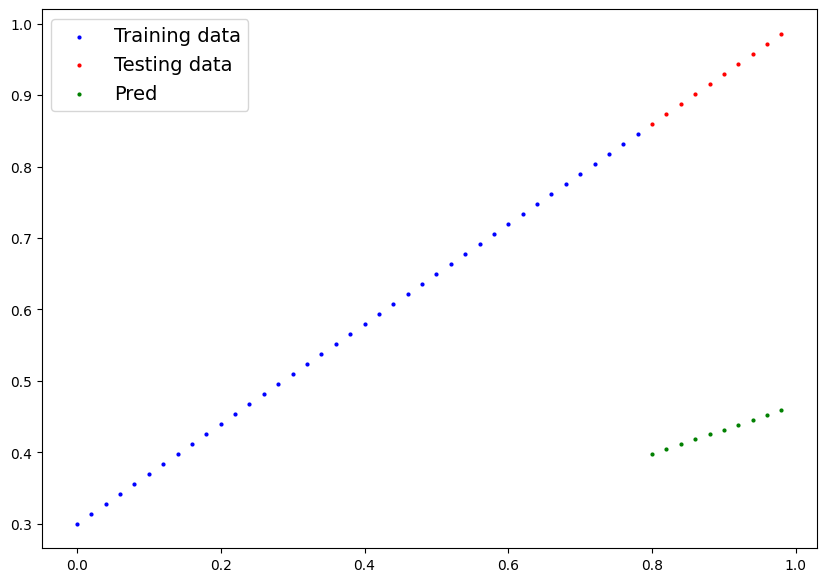

In [105]:
plot_predictions(predictions=y_preds)

## 3. Train model

loss function, cost function, criterion

In [106]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [107]:
# Set up a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer
optimizer = torch.optim.SGD(model_0.parameters(),
                             lr=1e-3)


### Building a training loop in <span style="color:red">PyTorch</span>

A couple of things we need in a training loop:
0. Loop through the data
1. Forward pass - also called Forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Opimizer zero grad
4. Loss backward
5. Optimizer step

In [145]:
torch.manual_seed(42)

epochs = 100

# 0. Loop through the data
for epoch in range(epochs):
    # Set the model to training mode
    model_0.train()

    # 1. Forward pass
    y_pred = model_0(X_train)

    # 2. Calculate the Loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform backpropagation on the loss with respect to the parameters of the model
    loss.backward()

    # 5. Step the optim
    optimizer.step()


 
    # turns off gradient tracking
    model_0.eval()
    with torch.inference_mode():
        test_pred = model_0(X_test)

        test_loss = loss_fn(test_pred, y_test)

    if epoch % 10 == 0 :

        print(f"Epoch: {epoch} | Loss : {loss} | Test Loss: {test_loss}")

        print(model_0.state_dict())

Epoch: 0 | Loss : 0.02027226611971855 | Test Loss: 0.047294992953538895
OrderedDict([('weights', tensor([0.5993])), ('bias', tensor([0.3423]))])
Epoch: 10 | Loss : 0.019929300993680954 | Test Loss: 0.04653624817728996
OrderedDict([('weights', tensor([0.6010])), ('bias', tensor([0.3416]))])
Epoch: 20 | Loss : 0.019585730507969856 | Test Loss: 0.04570891708135605
OrderedDict([('weights', tensor([0.6027])), ('bias', tensor([0.3409]))])
Epoch: 30 | Loss : 0.019241902977228165 | Test Loss: 0.044950198382139206
OrderedDict([('weights', tensor([0.6044])), ('bias', tensor([0.3401]))])
Epoch: 40 | Loss : 0.018899032846093178 | Test Loss: 0.04412282630801201
OrderedDict([('weights', tensor([0.6061])), ('bias', tensor([0.3394]))])
Epoch: 50 | Loss : 0.018555305898189545 | Test Loss: 0.04329545423388481
OrderedDict([('weights', tensor([0.6079])), ('bias', tensor([0.3387]))])
Epoch: 60 | Loss : 0.018211644142866135 | Test Loss: 0.042536746710538864
OrderedDict([('weights', tensor([0.6096])), ('bias

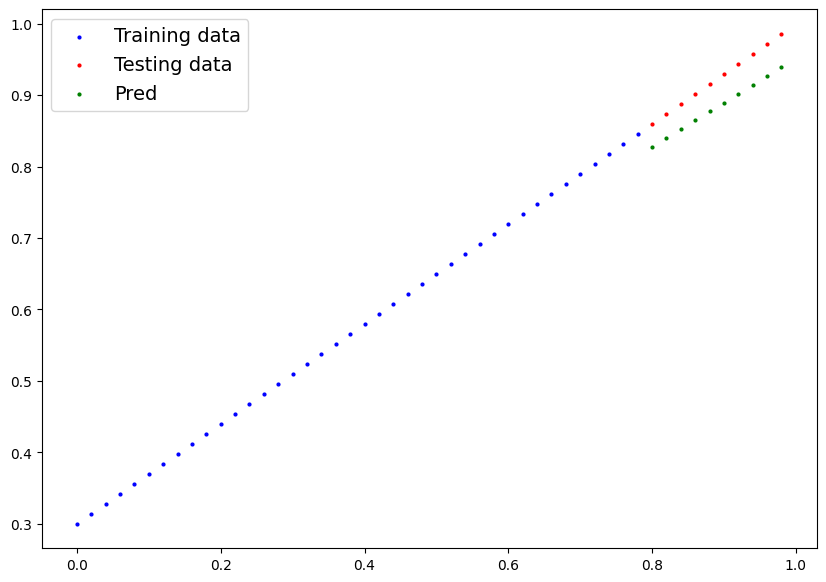

In [146]:
with torch.inference_mode():
    y_pred_new = model_0(X_test)

plot_predictions(predictions=y_pred_new)

## Saving a model in PyTorch

There are three main methods. - saving & loading models

1. `torch.save` -> pkl format
2. `torch.load`
3. `torch.nn.Module.load_state_dict` -> allows to load a model's saved state dictionary


[Pytorch Save & Load](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference)

In [147]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6162])), ('bias', tensor([0.3352]))])

In [151]:
MODEL_PATH = 'models'
MODEL_NAME = '01_pytorch_workflow_model_0.pth'

In [154]:
import os
import sys
if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

# Save the model state_dict

torch.save(model_0.state_dict(),os.path.join(MODEL_PATH,MODEL_NAME))

## Loading a PyTorch model

In [155]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6162])), ('bias', tensor([0.3352]))])

In [173]:
# torch.manual_seed()

# To load in a save state_dict we have to instantiate a new instace of our model class
loaded_model_0 = LinearRegressionModel()

print('Before: ',loaded_model_0.state_dict())
# Load the saved state_dict
loaded_model_0.load_state_dict(torch.load(os.path.join(MODEL_PATH, MODEL_NAME)))
print('After :', loaded_model_0.state_dict())


Before:  OrderedDict([('weights', tensor([-1.1920])), ('bias', tensor([1.9050]))])
After : OrderedDict([('weights', tensor([0.6162])), ('bias', tensor([0.3352]))])


In [174]:
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8281],
        [0.8405],
        [0.8528],
        [0.8651],
        [0.8774],
        [0.8898],
        [0.9021],
        [0.9144],
        [0.9267],
        [0.9391]])

In [175]:
y_pred_new

tensor([[0.8281],
        [0.8405],
        [0.8528],
        [0.8651],
        [0.8774],
        [0.8898],
        [0.9021],
        [0.9144],
        [0.9267],
        [0.9391]])